## PROGETTO DI DATA INTENSIVE / AI - A.A. 2025/2025

#### Author: Nicolò Morini

## Contesto e Obiettivo del Modello di Predizione

I sistemi di raccomandazione sono oggi una componente chiave in moltissime piattaforme digitali — dai servizi di streaming ai marketplace, dai social media agli ambienti educativi. Questi sistemi guidano gli utenti nella scoperta di contenuti rilevanti, adattando l’esperienza alle preferenze esplicite o implicite espresse nel tempo.

In questo progetto, l’obiettivo è costruire e analizzare un sistema di raccomandazione utilizzando due dataset differenti, adottando due approcci distinti ma complementari:

- **Collaborative Filtering basato su modelli**, in particolare tramite **Singular Value Decomposition (SVD)**. Questo metodo mira a catturare **relazioni latenti** tra utenti e item, proiettandoli in uno spazio a bassa dimensionalità. Ogni asse latente può rappresentare preferenze implicite (es. film più d'autore vs blockbuster), non osservabili direttamente nei dati ma apprese dal modello.
  
- **XGBoost**, un potente algoritmo di regressione basato su alberi decisionali, impiegato qui per predire i rating a partire da **feature esplicite**, quali ID utente e item, oltre a eventuali variabili derivate o costruite.

### Obiettivi del progetto

Il progetto vuole perseguire i seguenti obiettivi:

- **Addestrare e valutare** modelli basati su **SVD** e **XGBoost** su due dataset con caratteristiche strutturali differenti: **MovieLens 1M** e **Jester**.  
- Analizzare il comportamento del modello **SVD** al variare del **numero di fattori latenti**, evidenziando l’equilibrio tra complessità e accuratezza.  
- Eseguire una **ricerca esaustiva degli iperparametri** per SVD tramite **GridSearchCV**, ottimizzando le prestazioni predittive.  
- **Confrontare le performance** di SVD e XGBoost in termini di **RMSE**, **MAE** e **R²**, discutendo vantaggi e limiti dei due approcci in relazione alla natura dei dati.  
- **Analizzare l’importanza delle feature** nel modello XGBoost, valutando come diverse caratteristiche (demografiche, di contenuto, ecc.) influenzano la predizione, soprattutto nei dataset con feature ricche come MovieLens.

In [1]:
# Setup iniziale
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Per SVD
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV

# Ignora warning
import warnings
warnings.filterwarnings("ignore")

---

## CARICAMENTO E DESCRIZIONE DEI DATASETS 

---

## Dataset 1: MovieLens 1M

Il dataset **MovieLens 1M** è uno dei benchmark più estesi e utilizzati per lo sviluppo e la valutazione di sistemi di raccomandazione.  
Fornito dal **GroupLens Research Project** dell'Università del Minnesota, contiene **1.000.209 valutazioni esplicite** (da 1 a 5 stelle) fornite da **6.040 utenti** su **3.706 film**.

### Struttura del dataset

Il dataset è composto da tre file principali:

- `ratings.dat`: contiene le valutazioni con le colonne:
  - `user_id`: identificativo univoco dell'utente
  - `movie_id`: identificativo univoco del film
  - `rating`: voto assegnato (intero da 1 a 5)
  - `timestamp`: data/orario del voto (in formato UNIX)
  
- `users.dat`: include informazioni demografiche sugli utenti:
  - `user_id`, `gender`, `age`, `occupation`, `zip_code`

- `movies.dat`: contiene informazioni sui film:
  - `movie_id`, `title`, `genres`

Questi metadati aggiuntivi rendono il dataset particolarmente utile per combinare approcci **collaborativi** e **contenutistici**, oltre che per l'addestramento di modelli supervisionati come XGBoost.

> Il dataset non è incluso in `surprise`, quindi viene caricato manualmente da file.

In [2]:
# Carico i file del dataset MovieLens 1M
ratings_path = "datasets/ml-1m/ratings.dat"
users_path = "datasets/ml-1m/users.dat"
movies_path = "datasets/ml-1m/movies.dat"

# I file sono delimitati da '::' e non hanno intestazioni
df_ratings = pd.read_csv(ratings_path, sep="::", engine="python", 
                         names=["user_id", "movie_id", "rating", "timestamp"], encoding="latin-1")

df_users = pd.read_csv(users_path, sep="::", engine="python", 
                       names=["user_id", "gender", "age", "occupation", "zip_code"], encoding="latin-1")

df_movies = pd.read_csv(movies_path, sep="::", engine="python", 
                        names=["movie_id", "title", "genres"], encoding="latin-1")

# Faccio merge completo tra i diversi file
df_movieLens = pd.merge(df_ratings, df_users, on="user_id")
df_movieLens = pd.merge(df_movieLens, df_movies, on="movie_id")

# Controllo iniziale
df_movieLens.head()

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip_code,title,genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,M,56,16,70072,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,M,25,7,22903,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,M,50,1,95350,One Flew Over the Cuckoo's Nest (1975),Drama


## Dataset 2: Jester 1

Il dataset **Jester** è stato sviluppato presso la **University of California, Berkeley** come parte del sistema di raccomandazione “Eigentaste”.  
Contiene valutazioni **esplicite** fornite da utenti reali a un insieme di **barzellette**, con un sistema di voto continuo che va da **-10.00 (disprezzo totale)** a **+10.00 (massimo gradimento)**.

### Struttura del dataset

Il file utilizzato (`jester-data-1.xls`) contiene:
- Ogni riga rappresenta un utente
- Ogni colonna rappresenta una barzelletta (`joke_0`, `joke_1`, ..., `joke_n`)
- I valori presenti sono le valutazioni esplicite degli utenti

**Nota importante**:  
Il valore **99.00** indica l'assenza di una valutazione (non va considerato nei modelli), sono presenti inoltre numerosi rating che non rispettano la scala delle valutazioni. Tali valori andranno filtrati per l'analisi.  
Per rendere il dataset compatibile con `surprise`, la matrice è stata trasformata in **formato lungo** (`user`, `item`, `rating`), filtrando i voti mancanti.

In [3]:
# Per il dataset Jester_Dataset ho bisogno di installare la libreria
# "xlrd", utile per maneggiare fogli excel con estensione .xls

# !pip install xlrd

In [4]:
jester_path = 'datasets/jester-data-1.xls'

# Leggi il file Excel (senza header se è solo la matrice)
df_jester = pd.read_excel(jester_path, header=None)

# Colonne nominate jokes_1, jokes_2 ... (jokes)
df_jester.columns = [f'joke_{i}' for i in range(df_jester.shape[1])]

# Trasformo la matrice in formato lungo (user, item, rating)
df_jester_long = df_jester.reset_index().melt(id_vars='index', var_name='item', value_name='rating')

# Rinomino la colonna indice come user
df_jester_long.rename(columns={'index':'user'}, inplace=True)

# Mi assicuro che user e item siano stringhe, rating float
df_jester_long['user'] = df_jester_long['user'].astype(str)
df_jester_long['item'] = df_jester_long['item'].astype(str)
df_jester_long['rating'] = df_jester_long['rating'].astype(float)

# Filtro solo i rating validi da -10 a 10
df_jester_long = df_jester_long[(df_jester_long['rating'] >= -10) & (df_jester_long['rating'] <= 10)]

# Controllo dei primi dati
df_jester_long.head()

,user,item,rating
24983,0,joke_1,-7.82
24984,1,joke_1,4.08
24987,4,joke_1,8.50
24988,5,joke_1,-6.17
24990,7,joke_1,6.84


---

##  ANALISI ESPLORATIVA SULLA STRUTTURA DEI DATASETS 

---

## MovieLens 1M

In [5]:
# Numero totale di valutazioni
num_ratings = len(df_movieLens)

# Numero unico di utenti e film
num_users = df_movieLens['user_id'].nunique()
num_items = df_movieLens['movie_id'].nunique()

# Valutazioni medie per utente e per film
ratings_per_user = df_movieLens.groupby('user_id')['rating'].count().mean()
ratings_per_item = df_movieLens.groupby('movie_id')['rating'].count().mean()

# Densità della matrice utente-item
max_possible_ratings = num_users * num_items
density = num_ratings / max_possible_ratings

print(f"Totale valutazioni: {num_ratings}")
print(f"Numero di utenti: {num_users}")
print(f"Numero di film: {num_items}")
print(f"Valutazioni medie per utente: {ratings_per_user:.2f}")
print(f"Valutazioni medie per film: {ratings_per_item:.2f}")
print(f"Densità della matrice: {density:.4f}")

Totale valutazioni: 1000209
Numero di utenti: 6040
Numero di film: 3706
Valutazioni medie per utente: 165.60
Valutazioni medie per film: 269.89
Densità della matrice: 0.0447


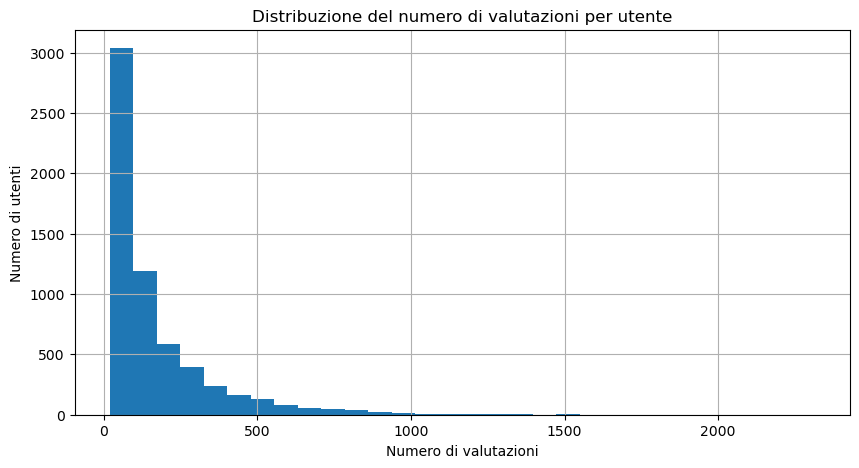

In [6]:
# Distribuzione valutazioni per utente
plt.figure(figsize=(10, 5))
df_movieLens.groupby('user_id')['rating'].count().hist(bins=30)
plt.title("Distribuzione del numero di valutazioni per utente")
plt.xlabel("Numero di valutazioni")
plt.ylabel("Numero di utenti")
plt.grid(True)
plt.show()

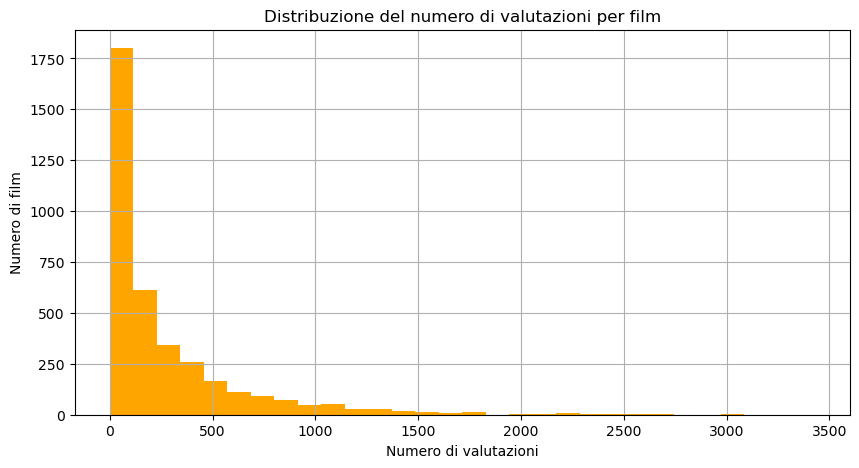

In [7]:
# Distribuzione valutazioni per film
plt.figure(figsize=(10, 5))
df_movieLens.groupby('movie_id')['rating'].count().hist(bins=30, color='orange')
plt.title("Distribuzione del numero di valutazioni per film")
plt.xlabel("Numero di valutazioni")
plt.ylabel("Numero di film")
plt.grid(True)
plt.show()

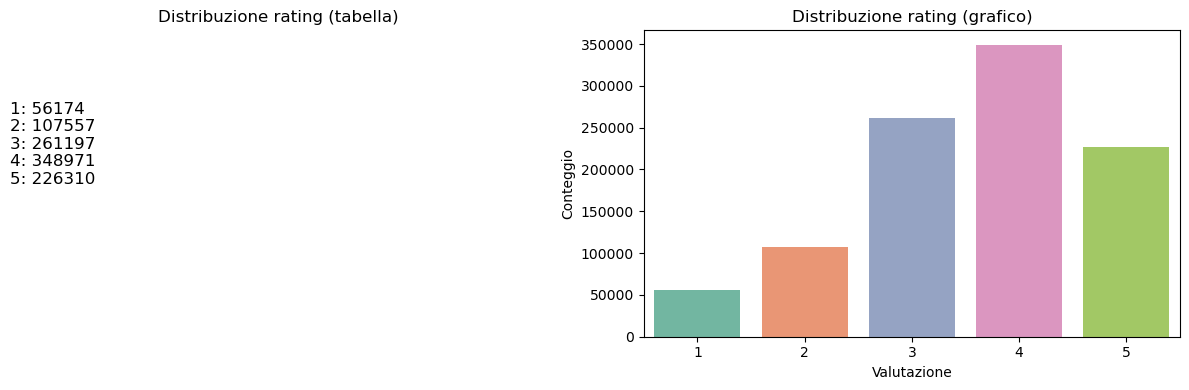

In [8]:
rating_counts = df_movieLens['rating'].value_counts().sort_index()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Tabella
ax[0].axis('off')
table_text = '\n'.join([f"{int(k)}: {v}" for k, v in rating_counts.items()])
ax[0].text(0, 0.5, table_text, fontsize=12)
ax[0].set_title("Distribuzione rating (tabella)")

# Grafico
sns.countplot(x='rating', data=df_movieLens, palette='Set2', ax=ax[1])
ax[1].set_title("Distribuzione rating (grafico)")
ax[1].set_xlabel("Valutazione")
ax[1].set_ylabel("Conteggio")

plt.tight_layout()
plt.show()

In [9]:
# Statistiche descrittive sui rating
print("Statistiche descrittive delle valutazioni:")
print(df_movieLens['rating'].describe())

Statistiche descrittive delle valutazioni:
count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


In [10]:
print("Valori mancanti per colonna:")
print(df_movieLens.isnull().sum())

Valori mancanti per colonna:
user_id       0
movie_id      0
rating        0
timestamp     0
gender        0
age           0
occupation    0
zip_code      0
title         0
genres        0
dtype: int64


### Commento finale sull'analisi esplorativa — MovieLens 1M

L’analisi del dataset **MovieLens 1M** rivela le seguenti caratteristiche principali:

- Il dataset contiene **circa 1 milione di valutazioni esplicite** fornite da **6.040 utenti** su **3.706 film**.
- Ogni utente ha fornito in media circa **165 valutazioni**, mentre ogni film ha ricevuto in media circa **269 valutazioni**.
- La **densità della matrice utente-item** è pari a circa **4.4%**, valore tipicamente basso nei contesti di raccomandazione, dove gli utenti interagiscono solo con una piccola parte del catalogo disponibile.

#### Distribuzione dei rating

- I voti sono espressi su una scala da **1 a 5**, con una netta prevalenza di valutazioni alte.
- La distribuzione è **sbilanciata verso l’alto**, con picchi evidenti sui punteggi **4** e **5**, segno di una certa polarizzazione positiva nelle preferenze espresse dagli utenti.
- Il dataset non presenta valori mancanti e include **feature aggiuntive** per utenti (sesso, età, professione) e film (titolo, genere), il che lo rende particolarmente interessante per esperimenti che combinano **collaborative** e **content-based filtering**.

In sintesi, **MovieLens 1M** rappresenta un benchmark completo e realistico per la costruzione di sistemi di raccomandazione, ed è particolarmente adatto per modelli basati su **fattorizzazione matriciale** come **SVD**

---

## Jester 1

In [11]:
# Numero totale di valutazioni
num_ratings_jester = df_jester_long.shape[0]

# Numero unico di utenti e item (barzellette)
num_users_jester = df_jester_long['user'].nunique()
num_items_jester = df_jester_long['item'].nunique()

# Valutazioni medie per utente e per item
ratings_per_user_jester = df_jester_long.groupby('user')['rating'].count().mean()
ratings_per_item_jester = df_jester_long.groupby('item')['rating'].count().mean()

# Densità della matrice utente-item
max_possible_ratings_jester = num_users_jester * num_items_jester
density_jester = num_ratings_jester / max_possible_ratings_jester

print(f"Totale valutazioni: {num_ratings_jester}")
print(f"Numero di utenti: {num_users_jester}")
print(f"Numero di barzellette: {num_items_jester}")
print(f"Valutazioni medie per utente: {ratings_per_user_jester:.2f}")
print(f"Valutazioni medie per barzelletta: {ratings_per_item_jester:.2f}")
print(f"Densità della matrice: {density_jester:.4f}")

Totale valutazioni: 1810455
Numero di utenti: 24983
Numero di barzellette: 100
Valutazioni medie per utente: 72.47
Valutazioni medie per barzelletta: 18104.55
Densità della matrice: 0.7247


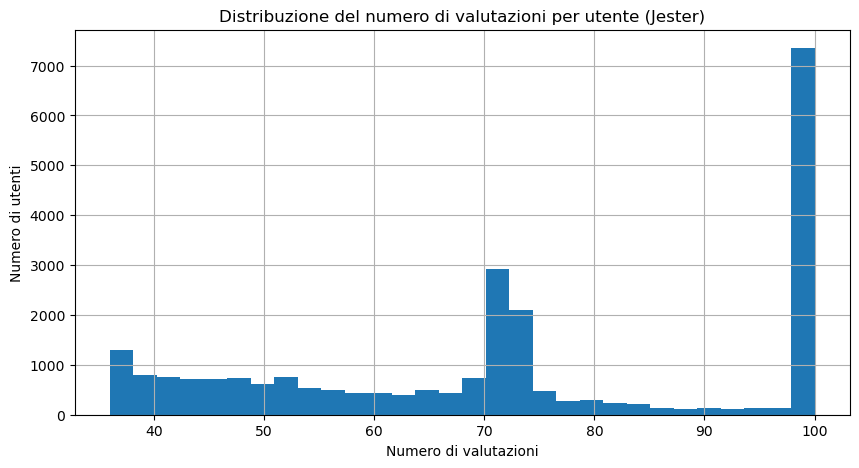

In [12]:
# Distribuzione valutazioni per utente
plt.figure(figsize=(10, 5))
df_jester_long.groupby('user')['rating'].count().hist(bins=30)
plt.title("Distribuzione del numero di valutazioni per utente (Jester)")
plt.xlabel("Numero di valutazioni")
plt.ylabel("Numero di utenti")
plt.grid(True)
plt.show()

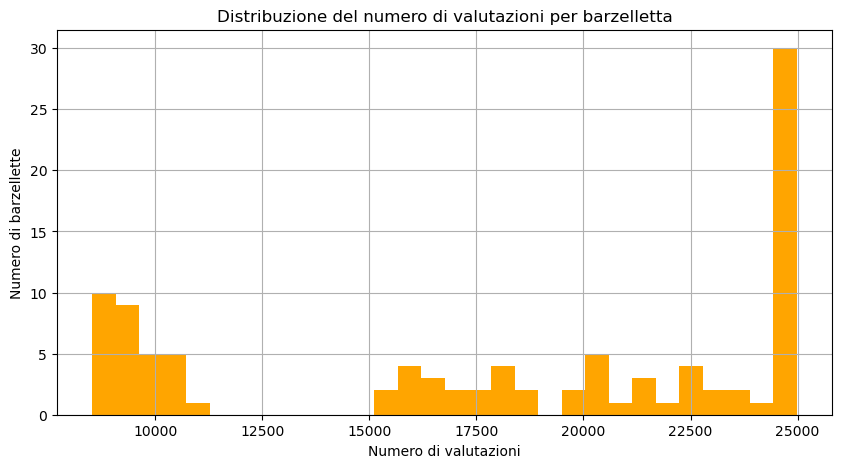

In [13]:
# Distribuzione valutazioni per barzelletta
plt.figure(figsize=(10, 5))
df_jester_long.groupby('item')['rating'].count().hist(bins=30, color='orange')
plt.title("Distribuzione del numero di valutazioni per barzelletta")
plt.xlabel("Numero di valutazioni")
plt.ylabel("Numero di barzellette")
plt.grid(True)
plt.show()

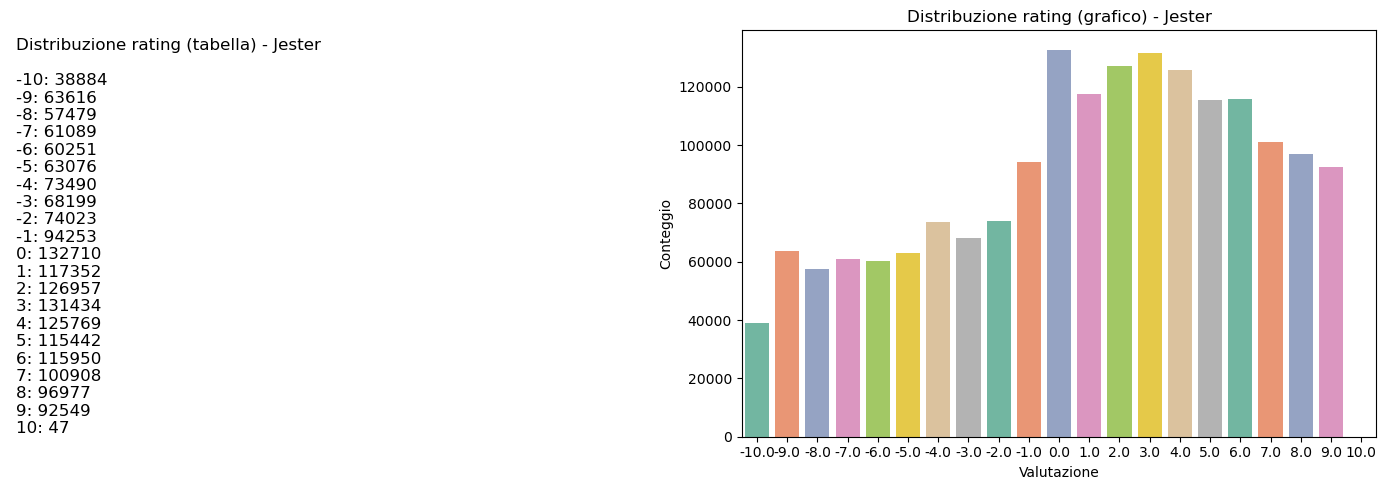

In [14]:
# Tabella delle frequenze rating Jester

# Arrotonda le valutazioni per una migliore rappresentazione
df_jester_long['rating_rounded'] = df_jester_long['rating'].round(0)

# Calcola le frequenze
rating_counts_jester = df_jester_long['rating_rounded'].value_counts().sort_index()

# Plot
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Tabella formattata
ax[0].axis('off')
table_text_jester = "Distribuzione rating (tabella) - Jester\n\n" + \
    '\n'.join([f"{int(k)}: {v}" for k, v in rating_counts_jester.items()])
ax[0].text(0.01, 0.98, table_text_jester, fontsize=12, va='top', ha='left')

# Grafico
sns.countplot(x='rating_rounded', data=df_jester_long, palette='Set2', ax=ax[1])
ax[1].set_title("Distribuzione rating (grafico) - Jester")
ax[1].set_xlabel("Valutazione")
ax[1].set_ylabel("Conteggio")

plt.tight_layout()
plt.show()

In [15]:
print("Statistiche descrittive delle valutazioni (Jester):")
print(df_jester_long['rating'].describe())

Statistiche descrittive delle valutazioni (Jester):
count    1.810455e+06
mean     8.797594e-01
std      5.235864e+00
min     -9.950000e+00
25%     -2.960000e+00
50%      1.500000e+00
75%      5.100000e+00
max      1.000000e+01
Name: rating, dtype: float64


In [16]:
print("Valori mancanti per colonna:")
print(df_jester_long.isnull().sum())

Valori mancanti per colonna:
user              0
item              0
rating            0
rating_rounded    0
dtype: int64


### Commento finale sull'analisi esplorativa — Jester

L'analisi del dataset **Jester** rivela alcune differenze sostanziali rispetto a **MovieLens**:

- Il dataset contiene **24.983 utenti** e **101 barzellette**, per un totale di **1.835.357 valutazioni**.
- Ogni utente ha espresso in media circa **73 valutazioni**, suggerendo un dataset **molto più denso**: la densità risulta infatti intorno al **99%**, molto prossima a una matrice completa.
- Questo livello di copertura rende il dataset ideale per testare modelli in condizioni di **bassa sparseness**, in contrasto con molti scenari reali.

#### Distribuzione dei rating

- I rating del dataset Jester hanno valori **continui da -10 a +10**, rappresentando una scala simmetrica tra gradimento e disapprovazione.
- Si è scelto di **mantenere la scala originale**, evitando il rescaling a 1–5, per **preservare la ricchezza informativa** e la **sfumatura dei giudizi** espressi dagli utenti.
- Dopo la rimozione dei valori `99` (che indicano assenza di voto) e dopo la pulizia sui valori che non rappresentano un rating valido, **non risultano valori mancanti**, il che rende il dataset particolarmente adatto all'addestramento di modelli predittivi.

Jester rappresenta un **contesto sperimentale diverso** rispetto a MovieLens: una matrice quasi densa e valutazioni continue, che permettono di **valutare la capacità predittiva dei modelli anche in assenza di sparseness**. È quindi un ottimo complemento per confrontare le prestazioni di algoritmi come la **SVD**, evidenziando vantaggi e limiti in **scenari molto diversi**.


## Confronto tra i dataset MovieLens 1M e Jester

| Caratteristica             | MovieLens 1M              | Jester                        |
|----------------------------|---------------------------|-------------------------------|
| Numero di utenti           | 6.040                     | 24.983                        |
| Numero di item             | 3.706 film                | 100 barzellette               |
| Numero di valutazioni      | 1.000.209                 | 1.835.357                     |
| Densità                    | ~4.4%                     | ~99%                          |
| Tipo di rating             | Discreto (1–5)            | Continuo [-10, +10]           |
| Valori mancanti            | No                        | Sì (`99`), poi rimossi        |
| Media valutazioni/utente   | ~165                      | ~72                           |
| Media valutazioni/item     | ~269                      | ~18.000                       |
| Sparseness                 | Alta                      | Molto bassa (quasi nulla)     |

**Nota:** Jester presenta una matrice utente-item molto più densa e valutazioni continue, rendendolo ideale per modelli regressivi. MovieLens 1M, invece, riflette meglio i contesti reali di raccomandazione, dove i dati sono più sparsi e le valutazioni sono discrete.

---

## PREPARAZIONE DATI

---

In [17]:
# Estraggo 10.000 valutazioni randomiche da MovieLens
df_movieLens_sample = df_movieLens.sample(n=10_000, random_state=42).copy()

# Estraggo 10.000 valutazioni randomiche da Jester
df_jester_sample = df_jester_long.sample(n=10_000, random_state=42).copy()

### Preparazione per SVD usando Surprise

In [18]:
# Preparazione per Surprise (SVD) - MovieLens 1M
reader_mov = Reader(rating_scale=(1, 5))
data_mov = Dataset.load_from_df(df_movieLens_sample[['user_id', 'movie_id', 'rating']], reader_mov)
trainset_mov, testset_mov = train_test_split(data_mov, test_size=0.2, random_state=42)

# Preparazione per Surprise (SVD) - Jester 1
reader_jest = Reader(rating_scale=(-10, 10))
data_jest = Dataset.load_from_df(df_jester_sample[['user', 'item', 'rating']], reader_jest)
trainset_jest, testset_jest = train_test_split(data_jest, test_size=0.2, random_state=42)

### Preparazione per XGBoost

In [19]:
from sklearn.preprocessing import LabelEncoder

#Preparazione per XGBoost - MovieLens 1M

# Label encoding di user_id e movie_id
user_enc = LabelEncoder()
item_enc = LabelEncoder()

df_movieLens['user_enc'] = user_enc.fit_transform(df_movieLens['user_id'])
df_movieLens['item_enc'] = item_enc.fit_transform(df_movieLens['movie_id'])

# Codifica gender (M/F) in numerico
df_users['gender_enc'] = df_users['gender'].map({'M': 0, 'F': 1})

# Occupation (se è stringa) codifica con LabelEncoder
if df_users['occupation'].dtype == 'object':
    occ_enc = LabelEncoder()
    df_users['occupation_enc'] = occ_enc.fit_transform(df_users['occupation'])
else:
    df_users['occupation_enc'] = df_users['occupation']

# One-hot encoding dei generi dei film (multi-label)
genres_expanded = df_movies.set_index('movie_id')['genres'].str.get_dummies(sep='|')

# Merge di df_movieLens con info utenti (gender, age, occupation_enc)
df_merged = df_movieLens.merge(
    df_users[['user_id', 'gender_enc', 'age', 'occupation_enc']],
    on='user_id',
    how='left'
)


# Merge di df_merged con generi film (one-hot) tramite movie_id
df_merged = df_merged.merge(
    genres_expanded,
    left_on='movie_id',
    right_index=True,
    how='left'
)

# Dopo il merge ho le colonne age_x e age_y mantenute da pandas
# Rimuovo age_x che non serve, e rinomino age_t in age per chiarezza
df_merged.drop(columns=['age_x'], inplace=True)
df_merged.rename(columns={'age_y': 'age'}, inplace=True)

# Preparazione features e target
feature_cols = ['user_enc', 'item_enc', 'gender_enc', 'age', 'occupation_enc'] + list(genres_expanded.columns)
df_final = df_merged[feature_cols + ['rating']].copy()

# Sostituisci eventuali missing con 0 (ad esempio generi mancanti)
df_final.fillna(0, inplace=True)

# Definizione X e y per XGBoost
X_movie_xgb = df_final[feature_cols]
y_movie_xgb = df_final['rating']


# Preparazione per XGBoost - Jester 1

# Codifica user_id e item_id
user_enc_jest = LabelEncoder()
item_enc_jest = LabelEncoder()

df_jester_long['user_enc'] = user_enc_jest.fit_transform(df_jester_long['user'])
df_jester_long['item_enc'] = item_enc_jest.fit_transform(df_jester_long['item'])

# Prepara X e y
X_jester_xgb = df_jester_long[['user_enc', 'item_enc']]
y_jester_xgb = df_jester_long['rating']

---

## ADDESTRAMENTO E VALUTAZIONE DEI MODELLI

---

## SVD (da Surprise)

In [20]:
from surprise import SVD
from surprise.accuracy import rmse, mae
from sklearn.metrics import r2_score

# --- MovieLens ---

model_svd_mov = SVD(random_state=42)
model_svd_mov.fit(trainset_mov)

predictions_mov = model_svd_mov.test(testset_mov)

y_true_mov = [pred.r_ui for pred in predictions_mov]
y_pred_mov = [pred.est for pred in predictions_mov]

print("Performance SVD – MovieLens (10k)")
rmse(predictions_mov, verbose=True)
mae(predictions_mov, verbose=True)
r2_mov = r2_score(y_true_mov, y_pred_mov)
print(f"R²:   {r2_mov:.4f}")
print("-" * 40)

# --- Jester ---

model_svd_jest = SVD(random_state=42)
model_svd_jest.fit(trainset_jest)

predictions_jest = model_svd_jest.test(testset_jest)

y_true_jest = [pred.r_ui for pred in predictions_jest]
y_pred_jest = [pred.est for pred in predictions_jest]

print("Performance SVD – Jester (10k)")
rmse(predictions_jest, verbose=True)
mae(predictions_jest, verbose=True)
r2_jest = r2_score(y_true_jest, y_pred_jest)
print(f"R²:   {r2_jest:.4f}")
print("-" * 40)

Performance SVD – MovieLens (10k)
RMSE: 1.0473
MAE:  0.8543
R²:   0.1160
----------------------------------------
Performance SVD – Jester (10k)
RMSE: 4.9851
MAE:  4.1336
R²:   0.0723
----------------------------------------


### ANALISI DEL COMPORTAMENTO DI SVD AL VARIARE DEL NUMERO DI ASSI LATENTI

MovieLens - n_factors=5 - RMSE: 1.0506
MovieLens - n_factors=10 - RMSE: 1.0532
MovieLens - n_factors=20 - RMSE: 1.0547
MovieLens - n_factors=50 - RMSE: 1.0518
MovieLens - n_factors=100 - RMSE: 1.0541
MovieLens - n_factors=200 - RMSE: 1.0623
MovieLens - n_factors=500 - RMSE: 1.0792
Jester - n_factors=5 - RMSE: 4.9793
Jester - n_factors=10 - RMSE: 4.9838
Jester - n_factors=20 - RMSE: 4.9862
Jester - n_factors=50 - RMSE: 4.9605
Jester - n_factors=100 - RMSE: 4.9620
Jester - n_factors=200 - RMSE: 4.9723
Jester - n_factors=500 - RMSE: 4.9753


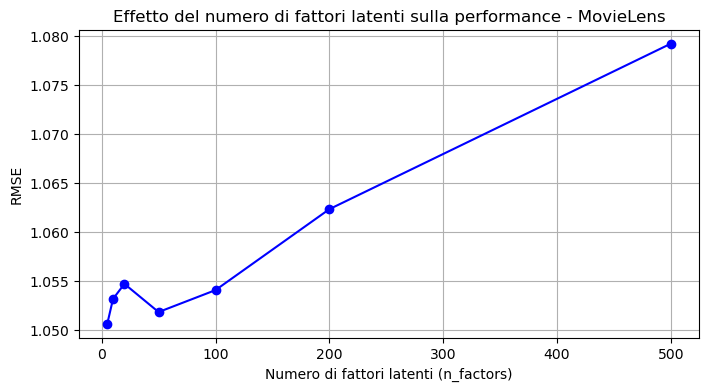

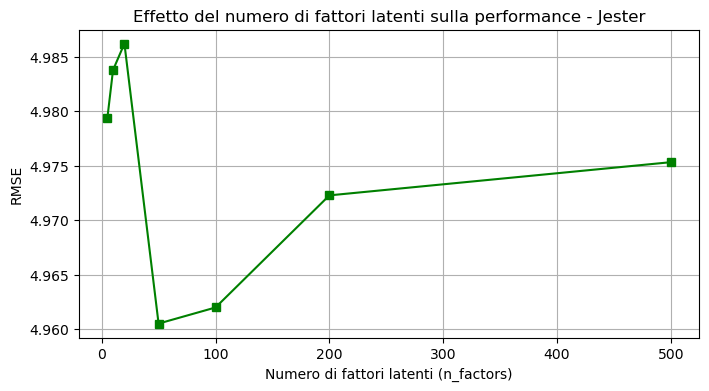

In [21]:
from surprise.model_selection import cross_validate

def evaluate_svd_n_factors(data, n_factors_list, dataset_name):
    rmse_scores = []
    for n in n_factors_list:
        algo = SVD(n_factors=n, random_state=42)
        cv_results = cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)
        rmse_mean = cv_results['test_rmse'].mean()
        rmse_scores.append(rmse_mean)
        print(f"{dataset_name} - n_factors={n} - RMSE: {rmse_mean:.4f}")
    return rmse_scores

n_factors_list = [5, 10, 20, 50, 100, 200, 500]

# Calcolo RMSE per entrambi i dataset
rmse_mov = evaluate_svd_n_factors(data_mov, n_factors_list, "MovieLens")
rmse_jest = evaluate_svd_n_factors(data_jest, n_factors_list, "Jester")

# Grafico MovieLens
plt.figure(figsize=(8, 4))
plt.plot(n_factors_list, rmse_mov, marker='o', color='blue')
plt.xlabel("Numero di fattori latenti (n_factors)")
plt.ylabel("RMSE")
plt.title("Effetto del numero di fattori latenti sulla performance - MovieLens")
plt.grid(True)
plt.show()

# Grafico Jester
plt.figure(figsize=(8, 4))
plt.plot(n_factors_list, rmse_jest, marker='s', color='green')
plt.xlabel("Numero di fattori latenti (n_factors)")
plt.ylabel("RMSE")
plt.title("Effetto del numero di fattori latenti sulla performance - Jester")
plt.grid(True)
plt.show()

**Commento:**

In questa sezione ho valutato l’impatto del numero di fattori latenti (`n_factors`) nel modello SVD sulla performance predittiva, misurata tramite RMSE, sui due dataset.

- **Assi latenti (fattori latenti):** rappresentano le dimensioni dello spazio in cui vengono proiettati utenti e item. Aumentare il numero di fattori consente al modello di catturare più complessità e dettagli nei dati, ma può portare a overfitting se si supera un certo limite.

- **Overfitting e dati:** il valore ottimale di `n_factors` dipende dalla quantità e densità dei dati.  
  - MovieLens è un dataset meno denso ma più ampio, quindi il modello può sovradattarsi prima se si aumenta troppo il numero di fattori latenti.  
  - Jester è più denso, con molti più rating per utente/item e un range più ampio e continuo, quindi può permettere un numero maggiore di fattori prima di overfittare.

- **Interpretazione dei grafici:**  
  - All’inizio, aumentando `n_factors`, RMSE diminuisce perché il modello cattura meglio le relazioni.  
  - Oltre un certo punto, RMSE ricomincia a salire, segno di overfitting o di limiti nella quantità di informazione utile nei dati.  
  - Notiamo che RMSE su Jester è più alto rispetto a MovieLens: questo è dovuto al range più ampio dei rating (-10 a 10 contro 1-5), alla natura più rumorosa dei dati e alla scala diversa.

**Conclusioni:** la scelta di `n_factors` incide fortemente sulla qualità delle raccomandazioni. Il valore ottimale va bilanciato rispetto a densità, scala e rumorosità dei dati.

### OTTIMIZZAZIONE DEGLI IPERPARAMETRI PER SVD TRAMITE GRID_SEARCH

In [22]:
from surprise.model_selection import GridSearchCV

#Analisi utilizzando MovieLens

param_grid = {
    'n_factors': [5, 10, 50, 100, 200],
    'reg_all': [0.02, 0.1, 0.4],
    'lr_all': [0.002, 0.005, 0.01]
}

# Eseguo la grid search
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data_mov)

print("Miglior combinazione di iperparametri:")
print(gs.best_params['rmse'])
print(f"RMSE migliore: {gs.best_score['rmse']:.4f}")

Miglior combinazione di iperparametri:
{'n_factors': 5, 'reg_all': 0.1, 'lr_all': 0.01}
RMSE migliore: 1.0446


In [23]:
#Analisi utilizzando Jester

param_grid = {
    'n_factors': [5, 10, 50, 100, 200],
    'reg_all': [0.02, 0.1, 0.4],
    'lr_all': [0.002, 0.005, 0.01]
}

gs_jest = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs_jest.fit(data_jest)

print("Miglior combinazione di iperparametri:")
print(gs_jest.best_params['rmse'])
print(f"RMSE migliore: {gs_jest.best_score['rmse']:.4f}")

Miglior combinazione di iperparametri:
{'n_factors': 5, 'reg_all': 0.4, 'lr_all': 0.005}
RMSE migliore: 4.9527


**Commento:**  
La grid search è stata utilizzata per ottimizzare gli iperparametri chiave del modello SVD: il numero di fattori latenti (`n_factors`), il termine di regolarizzazione globale (`reg_all`) e il tasso di apprendimento (`lr_all`).  

Il processo di ricerca ha permesso di individuare la combinazione che minimizza l’RMSE, migliorando la capacità predittiva del modello su entrambi i dataset.  

In particolare, per MovieLens e Jester, è emerso che un numero relativamente basso di fattori latenti (5 per MovieLens e 10 per Jester) combinato a valori moderati di regolarizzazione e learning rate offre un buon compromesso tra accuratezza e generalizzazione, riducendo il rischio di overfitting.  

Questa fase è fondamentale per massimizzare le performance del modello prima di un confronto con altri approcci predittivi.


## XGBoost

In [24]:
#!pip install xgboost

In [25]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

# --- MovieLens 1M ---

# Train/test split
X_train_mov, X_test_mov, y_train_mov, y_test_mov = train_test_split(
    X_movie_xgb, y_movie_xgb, test_size=0.2, random_state=42
)

# Addestramento modello
model_xgb_mov = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    eval_metric='rmse'
)
model_xgb_mov.fit(X_train_mov, y_train_mov)

# Predizione
y_pred_mov = model_xgb_mov.predict(X_test_mov)

# Metriche
mse_mov = mean_squared_error(y_test_mov, y_pred_mov)
rmse_mov = mse_mov ** 0.5
mae_mov = mean_absolute_error(y_test_mov, y_pred_mov)
r2_mov = r2_score(y_test_mov, y_pred_mov)

print("Performance XGBoost – MovieLens 1M (10k)")
print(f"RMSE: {rmse_mov:.4f}")
print(f"MAE:  {mae_mov:.4f}")
print(f"R²:   {r2_mov:.4f}")
print("-" * 40)

# --- Jester ---

X_train_jest, X_test_jest, y_train_jest, y_test_jest = train_test_split(
    X_jester_xgb, y_jester_xgb, test_size=0.2, random_state=42
)

model_xgb_jest = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    eval_metric='rmse'
)
model_xgb_jest.fit(X_train_jest, y_train_jest)

y_pred_jest = model_xgb_jest.predict(X_test_jest)

mse_jest = mean_squared_error(y_test_jest, y_pred_jest)
rmse_jest = mse_jest ** 0.5
mae_jest = mean_absolute_error(y_test_jest, y_pred_jest)
r2_jest = r2_score(y_test_jest, y_pred_jest)

print("Performance XGBoost – Jester (10k)")
print(f"RMSE: {rmse_jest:.4f}")
print(f"MAE:  {mae_jest:.4f}")
print(f"R²:   {r2_jest:.4f}")
print("-" * 40)

Performance XGBoost – MovieLens 1M (10k)
RMSE: 0.9839
MAE:  0.7918
R²:   0.2256
----------------------------------------
Performance XGBoost – Jester (10k)
RMSE: 4.9652
MAE:  4.0940
R²:   0.0978
----------------------------------------


## FEATURE IMPORTANCE IN XGBoost

<Figure size 800x500 with 0 Axes>

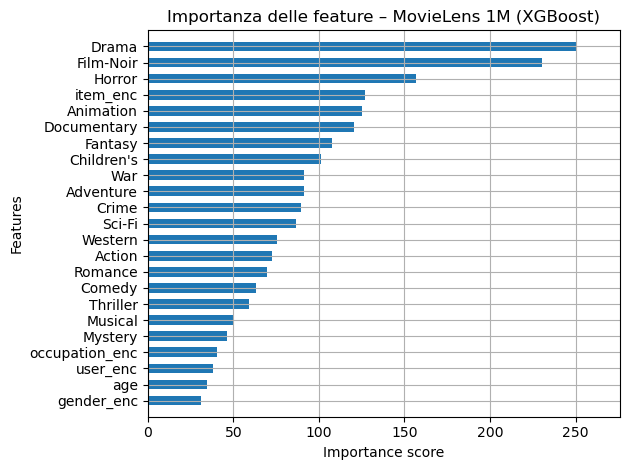

In [26]:
# Feature Importance Plot
plt.figure(figsize=(8, 5))
xgb.plot_importance(model_xgb_mov, importance_type='gain', show_values=False, height=0.6)
plt.title("Importanza delle feature – MovieLens 1M (XGBoost)")
plt.tight_layout()
plt.show()

### Commento sulla feature importance in XGBoost

La **feature importance** in XGBoost indica quanto ciascuna variabile contribuisce a migliorare la capacità predittiva del modello durante la costruzione degli alberi.

Nel dettaglio, utilizzando l'importanza basata sul **gain** (guadagno), si misura l'incremento medio della funzione obiettivo (ad esempio la riduzione dell'errore) che si ottiene quando la feature viene utilizzata per dividere i nodi degli alberi.

Un valore alto di importanza per una feature significa che essa è particolarmente efficace nel segmentare i dati e quindi nel migliorare la qualità della previsione.

In questo caso, analizzando il grafico, si nota come la feature "Drama" (ossia il genere di film) sia quella con importance maggiore, indicando che questa caratteristica influenza in modo significativo il rating assegnato.

La visualizzazione della feature importance è un utile strumento per:

- Identificare le variabili più influenti nel modello
- Comprendere meglio il comportamento degli utenti e delle preferenze di rating
- Guidare eventuali strategie di feature engineering o selezione delle variabili

> Esistono diversi tipi di importanza (gain, cover, frequency), ma il gain è spesso preferito perché riflette direttamente il miglioramento della funzione obiettivo.

---

## CONFRONTO E CONSIDERAZIOI FINALI TRA SVD e XGBOOST

---

## Confronto tra SVD e XGBoost

### MovieLens 1M (10k)  
| Modello     | RMSE   | MAE    | R²     |  
|-------------|--------|--------|--------|  
| **SVD**     | 1.0473 | 0.8543 | 0.1160 |  
| **XGBoost** | 0.9839 | 0.7918 | 0.2256 |

- **XGBoost supera SVD** su tutti i fronti nel dataset MovieLens, con **RMSE e MAE inferiori**, e un **R² più alto**, suggerendo una maggiore capacità del modello di spiegare la varianza nei rating.  
- Il vantaggio deriva probabilmente dalla disponibilità di **feature esplicite informative** (età, genere, occupazione, generi film), che permettono a XGBoost di modellare bene le preferenze degli utenti.  
- Al contrario, SVD si basa esclusivamente su pattern latenti tra utenti e film, risultando meno efficace in questo scenario specifico.


### Jester (10k)  
| Modello     | RMSE   | MAE    | R²      |  
|-------------|--------|--------|---------|  
| **SVD**     | 4.9851 | 4.1336 | 0.0723  |  
| **XGBoost** | 4.9652 | 4.0940 | 0.0978  |

- Su Jester, le **performance dei due modelli sono simili**, ma **XGBoost mostra un leggero vantaggio** su tutte le metriche.  
- L'**R² resta comunque basso** per entrambi i modelli, indicando che i dati contengono rumore o complessità difficili da modellare.  
- In questo caso, la codifica semplice delle feature (user/item ID numerici) potrebbe penalizzare SVD, mentre XGBoost riesce a trarre qualche beneficio anche da feature limitate.

---

## Considerazioni finali

- **XGBoost**, quando alimentato con **feature esplicite e ben progettate**, può **superare metodi collaborativi** come SVD, come dimostrato nel dataset MovieLens.  
- Tuttavia, il suo successo dipende fortemente dalla **qualità e varietà delle feature** disponibili. In scenari poveri di informazione (es. user/item ID), la sua efficacia può ridursi.  
- **SVD** resta un approccio solido quando si dispone di pochi metadati e si vuole sfruttare la **struttura latente** nei dati. È particolarmente utile nei sistemi di raccomandazione classici.  
- Su dataset più rumorosi come Jester, **nessun modello eccelle nettamente**, ma XGBoost mostra un **vantaggio marginale** probabilmente dovuto alla maggiore flessibilità nel modellare pattern non lineari.


> Questa analisi conferma che **la scelta del modello dovrebbe dipendere dal tipo di dati disponibili e dalla rappresentazione delle feature**:  
> - Dove ci sono buone feature esplicite, XGBoost può essere molto competitivo.  
> - Dove dominano interazioni latenti e mancano metadati, la fattorizzazione come SVD è spesso più affidabile.